# This is a playground implementation of the nonparametric Variable Clustering Model

### see: K. Palla et al. , A nonparametric variable clustering model. In NIPS 2012

##test run set up

In [1]:
# define test data as in official code by Palla et al.
D = 40
K = 2
N = 100

C = zeros(D, K)
C[1:20, 1] = 1
C[21:40, 2] = 1

cc = zeros(1,D)
cc[1:20] = 1
cc[21:40] = 2

# set random seed to be comparable
srand(12345)

In [3]:
# set G and X (factor loadings, and latent factors) of test data
G = mu_g + sigma_g * randn(D, K)
X = mu_x + sigma_x * randn(K, N)

# set noise
ϵ = mu_noise + sigma_noise * randn(D,N);

In [4]:
# test data
Y = (G .* C) * X + ϵ;

(D, N) = size(Y)

(40,100)

# load src implementations instead

In [132]:
include("../src/BNP.jl")

In [141]:
BNP.train(BNP.VCM(), BNP.Gibbs(), BNP.IncrementalInitialisation(), Y)

LoadError: BoundsError()
while loading In[141], in expression starting on line 1

In [127]:
spones(1)

LoadError: `spones` has no method matching spones(::Int64)
while loading In[127], in expression starting on line 1

### run sequential initialization

In [37]:
collect(3)

1-element Array{Int64,1}:
 3

In [19]:
(D, N) = size(Y)

# lets "forget" true value of X, G, C and cc 
X = randn(1,N)
G = randn(1,1)
C = ones(1,1)
cc = [1]
Ns = [1]

Yd = Y[1,:]
maskd = m_unobserved[1,:]

Yd[maskd] = 0
tic();
print("evaluate dimension: 1")

# run one iteration using Yd only
X = sample_latent_factors(Yd, C, sigma_noise, sigma_x, X, G)
(X, cc, C, G) = gibbs_aux_assignment(Yd, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α )
K = size(C, 2)
α = random_concentration_parameter(α, 1.0, 1.0, N, K)
sigma_noise = random_sigma_noise(Yd, G, C, X, noise_hyper_a, noise_hyper_b)
sigma_g = random_sigma_g(Yd, G, C, X, sigma_hyper_a, sigma_hyper_b)

# loop over D-1 dimensions
for d = 2:D
    YY = Y[d,:]
    YY[m_unobserved[d,:]] = 0.0
    Yd = cat(1, Yd, YY)
    
    print(" ", d)
    # sample unobserved data from model
    (X, cc, C, G) = gibbs_aux_assignment(Yd, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α, out_dim = d)
    # not sure why this is required...
    
    # run one iteration:
    X = sample_latent_factors(Yd, C, sigma_noise, sigma_x, X, G)
    (X, cc, C, G) = gibbs_aux_assignment(Yd, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α)
    K = size(C, 2)
    α = random_concentration_parameter(α, 1.0, 1.0, N, K)
    sigma_noise = random_sigma_noise(Yd, G, C, X, noise_hyper_a, noise_hyper_b)
    sigma_g = random_sigma_g(Yd, G, C, X, sigma_hyper_a, sigma_hyper_b)
    
    # actually sample unobserved data
    mask = m_unobserved[1:d,:]
    
    (dd, nn) = size(Yd)
    
    Yd[mask] = sample_vcm_data(nn, dd, G, X, C, mu_noise, sigma_noise)[mask]
    
end

t = toq();

println("")
println("finished [", t," sec].")

evaluate dimension: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
finished [0.970247778 sec].


In [39]:
G

40x2 Array{Float64,2}:
  0.823609    0.0      
  0.555605    0.0      
  0.293881    0.0      
  0.345574    0.0      
  0.471058    0.0      
  0.198374    0.0      
 -1.00863     0.0      
  0.0988807   0.0      
  1.01222     0.0      
 -0.131063    0.0      
  0.414347    0.0      
  1.3776      0.0      
 -0.395126    0.0      
  ⋮                    
  0.0        -0.130462 
  0.0         0.139803 
  0.0         0.902242 
  0.0        -0.292252 
  0.0         0.135014 
  0.0        -0.270944 
  0.0        -0.116162 
  0.0         0.190132 
  0.0        -0.658669 
  0.0        -0.421432 
  0.0         0.459295 
  0.0         0.0835281

### run inference

In [47]:
function univarnormal_logpdf(X::Array{Float64}, Mu::Array{Float64}; σ=1.0, n=1)
    
    E = X - Mu
    
    return n*(log(σ) + 0.5*log(2*pi)) - 0.5*sum(E.^2) / (σ^2)
end

univarnormal_logpdf (generic function with 1 method)

In [149]:
# compute energy
(D, N) = size(Y)

llh = univarnormal_logpdf(Y, (G.*C) * X, σ=sigma_noise, n = -D*N)

# simplified normal pdf
prior_g = -0.5 * (1/sigma_g.^2) * sum( (G-repmat((mu_g * ones(D, 1)), 1, K)).^2 )
#univarnormal_logpdf(G, repmat((mu_g * ones(D, 1)), 1, K), σ=sigma_g)
prior_x = -0.5 * (1/sigma_x.^2) * sum( (X-repmat((mu_x * ones(K, 1)), 1, N)).^2 )
#univarnormal_logpdf(X, repmat((mu_x * ones(K, 1)), 1, N), σ=sigma_x)

# dirichlet prior?
K = size(C, 2)
Ns = map(c -> sum(cc .== c), unique(cc))
prior_c = lgamma(α)+K*log(α) +sum(lgamma(Ns)) - lgamma(α+D)

println("llh: ", llh)
println("prior g: ", prior_g)
println("prior x: ", prior_x)
println("prior c: ", prior_c)

# energy
e = llh + prior_g + prior_x + prior_c

llh: -30.063463259880372
prior g: -0.4031262972959257
prior x: -9.53227155231162
prior c: -0.6305734283947919


-40.62943453788271

In [55]:
# define MCMC result object
type VCMS
    
    # energy
    energy::Float64
    
    # number of clusters
    K::Int
    
    # concentration parameter (Dirichlet)
    α::Float64
    
end

### burn-in phase

In [151]:
burnin = 0

(D, N) = size(Y)

for i in 1:burnin
    
    Y[m_unobserved] = sample_vcm_data(N, D, G, X, C, mu_noise, sigma_noise)[m_unobserved]
    
    # run one iteration
    X = sample_latent_factors(Y, C, sigma_noise, sigma_x, X, G)
    (X, cc, C, G) = gibbs_aux_assignment(Y, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α)
    K = size(C, 2)
    α = random_concentration_parameter(α, 1.0, 1.0, N, K)
    sigma_noise = random_sigma_noise(Y, G, C, X, noise_hyper_a, noise_hyper_b)
    sigma_g = random_sigma_g(Y, G, C, X, sigma_hyper_a, sigma_hyper_b)
end

### run Gibbs sampler with thinning

In [170]:
results = VariableClusteringSetting[]
thinout = 1
iterations = 1000

Px = zeros(iterations)
Pg = zeros(iterations)
Pc = zeros(iterations)
Pl = zeros(iterations)

for i in 1:iterations
    
    # run thinning (ignore some Gibbs sweeps if thinout > 1)
    for j in 1:thinout
        Y[m_unobserved] = sample_vcm_data(N, D, G, X, C, mu_noise, sigma_noise)[m_unobserved]
    
        # run one iteration
        X = sample_latent_factors(Y, C, sigma_noise, sigma_x, X, G)
        (X, cc, C, G) = gibbs_aux_assignment(Y, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α)
        K = size(C, 2)
        α = random_concentration_parameter(α, 1.0, 1.0, N, K)
        sigma_noise = random_sigma_noise(Y, G, C, X, noise_hyper_a, noise_hyper_b)
        sigma_g = random_sigma_g(Y, G, C, X, sigma_hyper_a, sigma_hyper_b)
    end
    
    # compute energy
    llh = univarnormal_logpdf(Y, (G.*C) * X, σ=sigma_noise, n = -D*N)

    # simplified normal pdf
    prior_g = -0.5 * (1/sigma_g.^2) * sum( (G-repmat((mu_g * ones(D, 1)), 1, K)).^2 )
    #univarnormal_logpdf(G, repmat((mu_g * ones(D, 1)), 1, K), σ=sigma_g)
    prior_x = -0.5 * (1/sigma_x.^2) * sum( (X-repmat((mu_x * ones(K, 1)), 1, N)).^2 )
    #univarnormal_logpdf(X, repmat((mu_x * ones(K, 1)), 1, N), σ=sigma_x)

    # dirichlet prior?
    K = size(C, 2)
    Ns = map(c -> sum(cc .== c), unique(cc))
    prior_c = lgamma(α)+K*log(α) +sum(lgamma(Ns)) - lgamma(α+D)

    # energy
    e = llh + prior_g + prior_x + prior_c
    
    Px[i] = prior_x
    Pc[i] = prior_c
    Pg[i] = prior_g
    Pl[i] = llh
    
    # store result of current Gibbs sweep
    push!(results, VariableClusteringSetting(e, X, G, C, α, sigma_noise, sigma_g))
   
    # println("iteration: ", i, " with energy: ", e, " K: ", K)
end

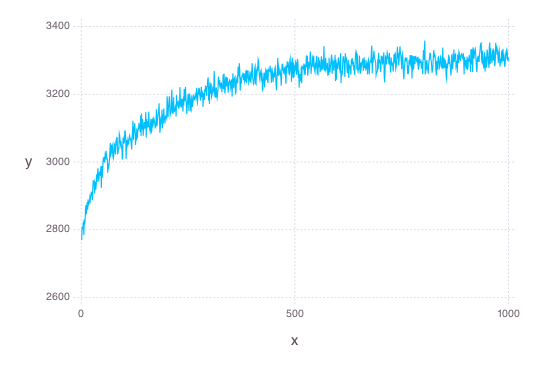

In [177]:
# do some plots
using Gadfly

E = map(vcm -> vcm.energy, results);
plot(x = [1:iterations], y = E, Geom.line)

In [94]:
C

Cy = zeros(D, K)
Cy[1:20, 1] = 1
Cy[21:40, 2] = 1

sum(abs(C - Cy))

0.0

In [88]:
using UCIMLRepo
using DataFrames

ucirepoinfo("ionosphere") 

fetching from the following url : http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.names
1. Title: Johns Hopkins University Ionosphere database
2. Source Information:
   -- Donor: Vince Sigillito (vgs@aplcen.apl.jhu.edu)
   -- Date: 1989
   -- Source: Space Physics Group
              Applied Physics Laboratory
              Johns Hopkins University
              Johns Hopkins Road
              Laurel, MD 20723 
3. Past Usage:
   -- Sigillito, V. G., Wing, S. P., Hutton, L. V., \& Baker, K. B. (1989).
      Classification of radar returns from the ionosphere using neural 
      networks. Johns Hopkins APL Technical Digest, 10, 262-266.
      They investigated using backprop and the perceptron training algorithm
      on this database.  Using the first 200 instances for training, which
      were carefully split almost 50% positive and 50% negative, they found
      that a "linear" perceptron attained 90.7%, a "non-linear" perceptron
      attained 92%, an

In [107]:
url = string("http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data")
dat = UCIMLRepo.download_http(url)

rows = ASCIIString[]
rows = split(dat,'\n',false)
df = DataFrame()

for i = 1:size(rows)[1]
    df[i] = filter(x -> length(x) > 0, split(rows[1],' '))
end


data = convert(Array, df)
classes = data[end,:]
Y = float(data[2:end-1,:])

fetching from the following url : http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data


8x1484 Array{Float64,2}:
 0.58  0.58  0.58  0.58  0.58  0.58  …  0.58  0.58  0.58  0.58  0.58  0.58
 0.61  0.61  0.61  0.61  0.61  0.61     0.61  0.61  0.61  0.61  0.61  0.61
 0.47  0.47  0.47  0.47  0.47  0.47     0.47  0.47  0.47  0.47  0.47  0.47
 0.13  0.13  0.13  0.13  0.13  0.13     0.13  0.13  0.13  0.13  0.13  0.13
 0.5   0.5   0.5   0.5   0.5   0.5      0.5   0.5   0.5   0.5   0.5   0.5 
 0.0   0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0 
 0.48  0.48  0.48  0.48  0.48  0.48     0.48  0.48  0.48  0.48  0.48  0.48
 0.22  0.22  0.22  0.22  0.22  0.22     0.22  0.22  0.22  0.22  0.22  0.22

In [115]:
data = convert(Array, ucirepodata("ionosphere"))

classes = data[end,:]
Y = float(data[1:end-1,:])

(D, N) = size(Y)

using StatsBase
Y = zscore(Y, 1)

fetching from the following url : http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data


34x351 Array{Float64,2}:
  1.5626      2.0915       1.47986   …   1.11855    1.17415    1.36846 
 -0.316606    0.202099    -0.652671     -1.0161    -0.884406  -0.925723
  1.55394     2.0915       1.47986       1.00544    0.980806   1.01768 
 -0.427272   -0.153656    -0.724431     -1.01682   -0.918516  -0.615252
  1.28528     1.9599       1.47986       0.973548   1.13549    0.763665
 -0.273271   -0.481033    -0.642328  …  -1.08498   -0.92535   -1.06684 
  1.25061    -0.00324088   1.47986       1.0156     1.08544    1.09024 
 -1.02522    -1.56632     -0.909896     -1.08933   -0.95946   -0.736224
  1.5626      2.0915       1.24453       1.02429    0.88072    1.11444 
 -0.245948    0.11615     -0.627123     -0.963882  -0.882141  -1.13539 
  1.28528     1.16331      0.905822  …   0.993123   0.962609   0.880599
 -0.650258   -1.07784     -0.538666     -0.978397  -0.952647  -0.772517
  0.806313    0.852658     1.16942       0.960484   0.948961   0.924945
  ⋮                                  ⋱ 

In [116]:
(D, N) = size(Y)

hold_out_perc = 0.1
hold_out = ceil(hold_out_perc * D * N)
per = randperm(D*N)

m_unobserved = bool( sparse( zeros(size(Y)) ) )
m_unobserved[per[1:hold_out]] = true;

# lets "forget" true value of X, G, C and cc 
X = randn(1,N)
G = randn(1,1)
C = ones(1,1)
cc = [1]
Ns = [1]

Yd = Y[1,:]
print("evaluate dimension: 1")

# run one iteration using Yd only
X = sample_latent_factors(Yd, C, sigma_noise, sigma_x, X, G)
(X, cc, C, G) = gibbs_aux_assignment(Yd, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α )
K = size(C, 2)
α = random_concentration_parameter(α, 1.0, 1.0, N, K)
sigma_noise = random_sigma_noise(Yd, G, C, X, noise_hyper_a, noise_hyper_b)
sigma_g = random_sigma_g(Yd, G, C, X, sigma_hyper_a, sigma_hyper_b)

# loop over D-1 dimensions
@time for d = 2:D
    YY = Y[d,:]
    Yd = cat(1, Yd, YY)
    
    print(" ", d)
    # sample unobserved data from model
    (X, cc, C, G) = gibbs_aux_assignment(Yd, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α, out_dim = d)
    # not sure why this is required...
    
    # run one iteration:
    X = sample_latent_factors(Yd, C, sigma_noise, sigma_x, X, G)
    (X, cc, C, G) = gibbs_aux_assignment(Yd, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α)
    K = size(C, 2)
    α = random_concentration_parameter(α, 1.0, 1.0, N, K)
    sigma_noise = random_sigma_noise(Yd, G, C, X, noise_hyper_a, noise_hyper_b)
    sigma_g = random_sigma_g(Yd, G, C, X, sigma_hyper_a, sigma_hyper_b)
    
    # actually sample unobserved data
    #Yd[mask] = sample_vcm_data(nn, dd, G, X, C, mu_noise, sigma_noise)[mask]
    #Yd = sample_vcm_data(nn, dd, G, X, C, mu_noise, sigma_noise)
    
    if d == D
        println("")
    end
end


evaluate dimension: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
elapsed time: 1.018739241 seconds (106061760 bytes allocated, 44.88% gc time)


In [106]:
typeof(m_unobserved)

SparseMatrixCSC{Bool,Int64} (constructor with 1 method)

In [44]:
burnin = 100

(D, N) = size(Y)

@time for i in 1:burnin
    
    Y = sample_vcm_data(N, D, G, X, C, mu_noise, sigma_noise)
    
    # run one iteration
    X = sample_latent_factors(Y, C, sigma_noise, sigma_x, X, G)
    (X, cc, C, G) = gibbs_aux_assignment(Y, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α)
    K = size(C, 2)
    α = random_concentration_parameter(α, 1.0, 1.0, N, K)
    sigma_noise = random_sigma_noise(Y, G, C, X, noise_hyper_a, noise_hyper_b)
    sigma_g = random_sigma_g(Y, G, C, X, sigma_hyper_a, sigma_hyper_b)
end

elapsed time: 1.62294928 seconds (215919760 bytes allocated, 42.57% gc time)


In [117]:
results = VCMS[]
thinout = 1
iterations = 100
@time for i in 1:iterations
    
    # run thinning (ignore some Gibbs sweeps if thinout > 1)
    for j in 1:thinout
        #Y[m_unobserved] = sample_vcm_data(N, D, G, X, C, mu_noise, sigma_noise)[m_unobserved]
    
        # run one iteration
        X = sample_latent_factors(Y, C, sigma_noise, sigma_x, X, G)
        (X, cc, C, G) = gibbs_aux_assignment(Y, X, cc, C, G, m_aux, sigma_noise, sigma_g, mu_g, α)
        K = size(C, 2)
        α = random_concentration_parameter(α, 1.0, 1.0, N, K)
        sigma_noise = random_sigma_noise(Y, G, C, X, noise_hyper_a, noise_hyper_b)
        sigma_g = random_sigma_g(Y, G, C, X, sigma_hyper_a, sigma_hyper_b)
    end
    
    # compute energy
    llh = univarnormal_logpdf(Y, (G.*C) * X, σ=sigma_noise, n = -D*N)

    # simplified normal pdf
    prior_g = -0.5 * (1/sigma_g.^2) * sum( (G-repmat((mu_g * ones(D, 1)), 1, K)).^2 )
    prior_x = -0.5 * (1/sigma_x.^2) * sum( (X-repmat((mu_x * ones(K, 1)), 1, N)).^2 )

    # dirichlet prior?
    K = size(C, 2)
    Ns = map(c -> sum(cc .== c), unique(cc))
    prior_c = lgamma(α)+K*log(α) +sum(lgamma(Ns)) - lgamma(α+D)

    # energy
    e = llh + prior_g + prior_x + prior_c
    #e = prior_x
    
    # store result of current Gibbs sweep
    push!(results, VCMS(e, K, α))
   
    #println("iteration: ", i, " with energy: ", e, " K: ", K)
end

elapsed time: 3.653033492 seconds (468716200 bytes allocated, 50.82% gc time)


In [118]:
# do some plots
using Gadfly

E = map(vcm -> vcm.energy, results);
K = map(vcm -> vcm.K, results);
A = map(vcm -> vcm.α, results);

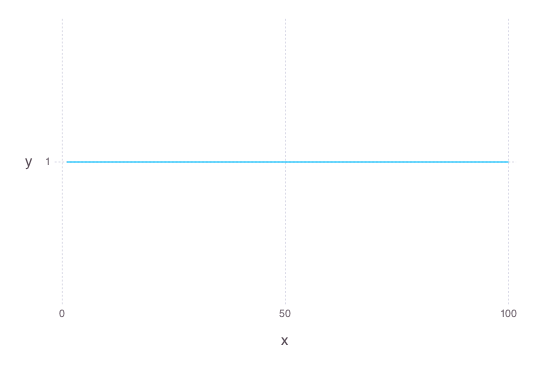

In [120]:
p1 = plot(x = [1:iterations], y = E, Geom.line)
p2 = plot(x = [1:iterations], y = K, Geom.line)
#p3 = plot(x = [1:iterations], y = A, Geom.line)

#vstack(p1, p2, p3)